In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from pathlib import Path
import matplotlib.pyplot as plt

Create quality control plots for each brain and trial

INFO: now processing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\Chrome\brain1\trial1
INFO: now parsing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\Chrome\brain1\trial1\ROI.csv
INFO: now processing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\Chrome\brain1\trial2
INFO: now parsing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\Chrome\brain1\trial2\ROI.csv
INFO: now processing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\Chrome\brain2\trial1
INFO: now parsing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\Chrome\brain2\trial1\ROI.csv
INFO: now processing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\Chrome\brain2\trial2
INFO: now parsing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\Chrome\brain2\trial2\ROI.csv
INFO: now processing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\Chrome\brain3\trial1
INFO: no

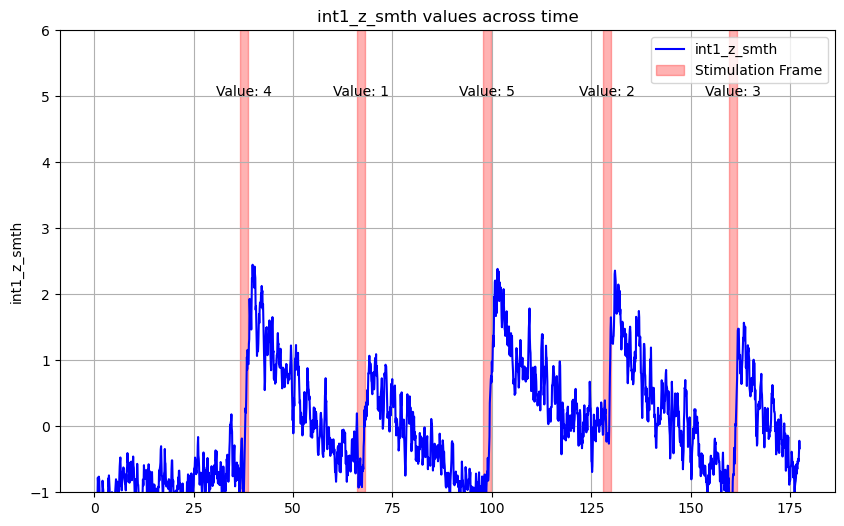

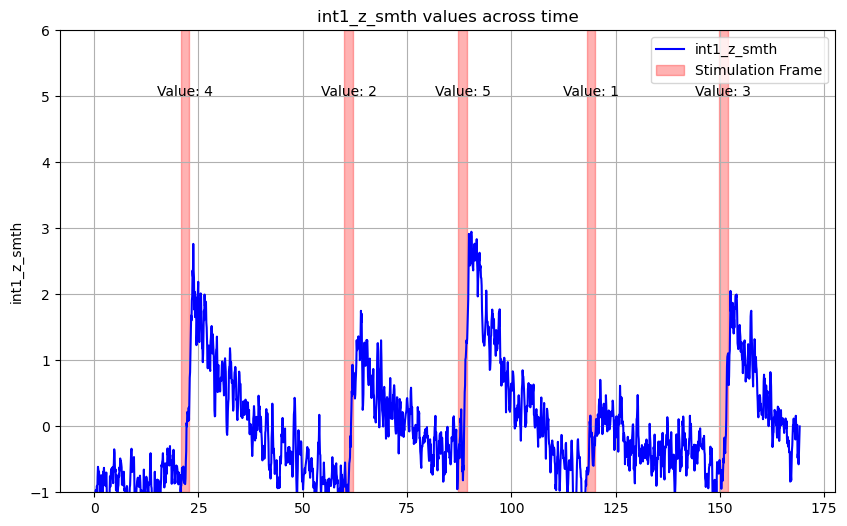

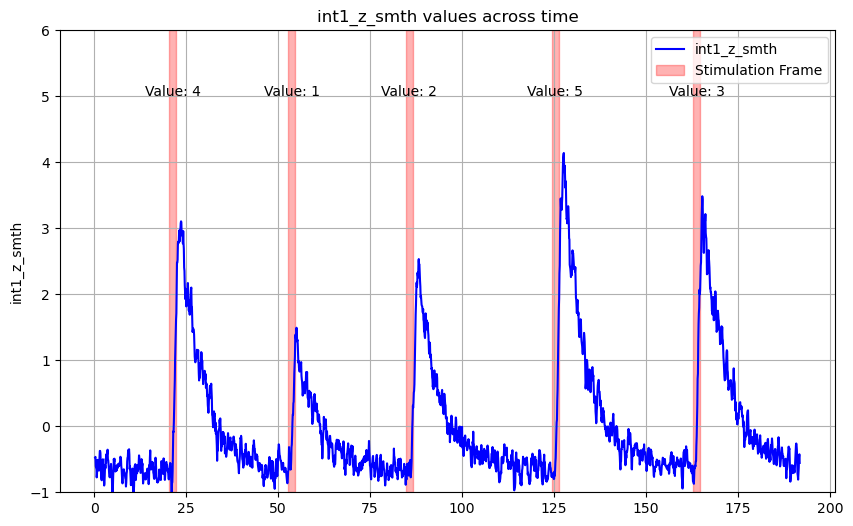

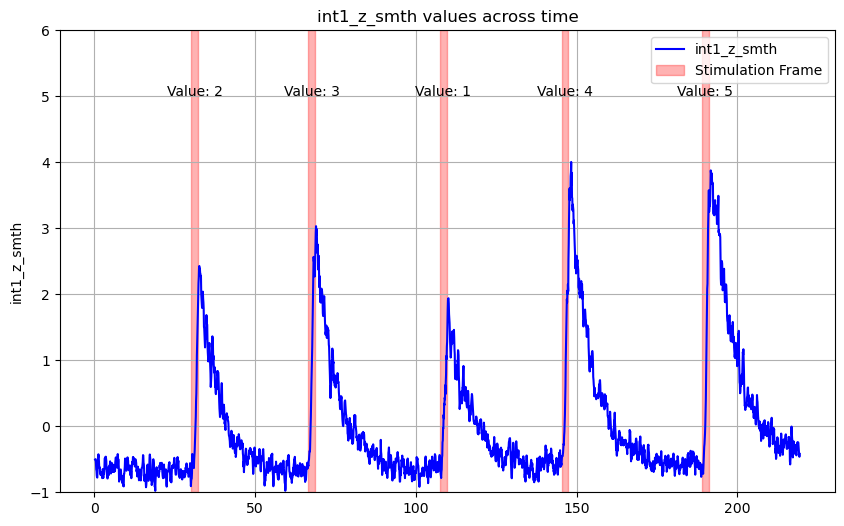

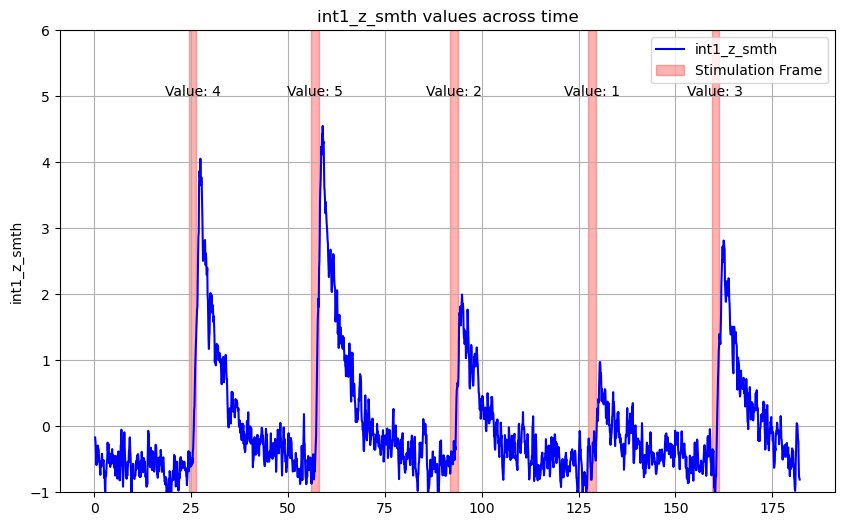

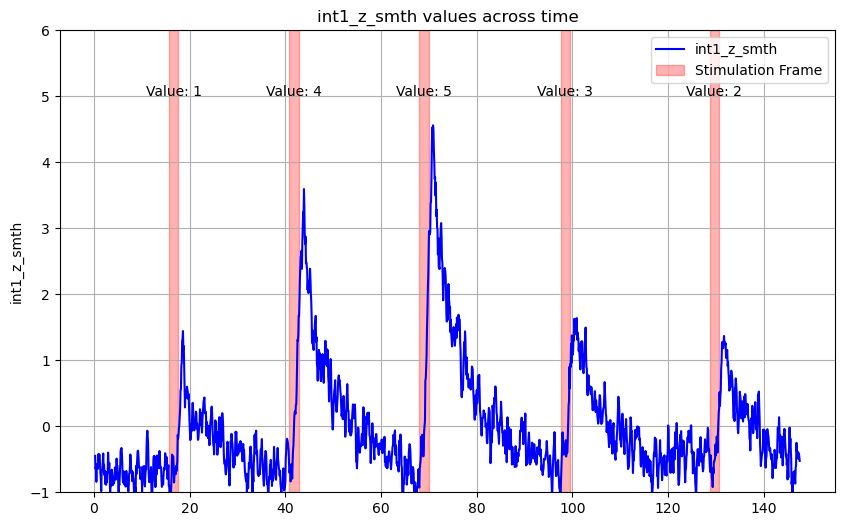

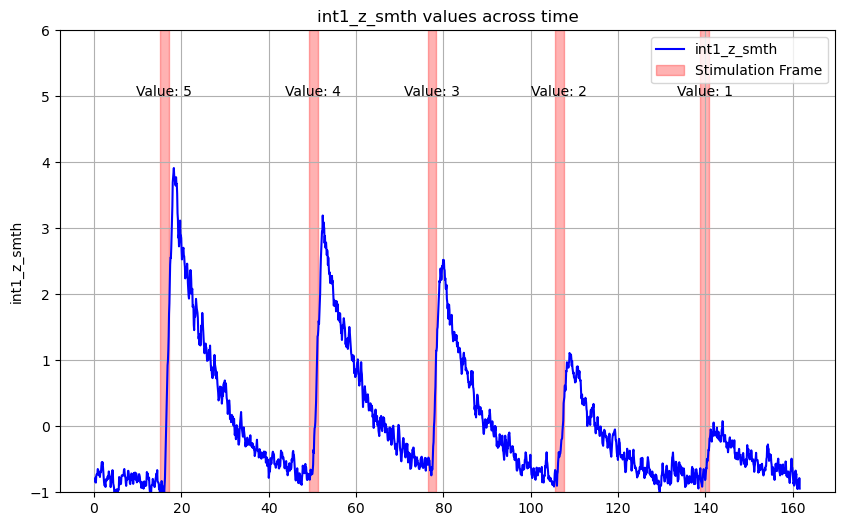

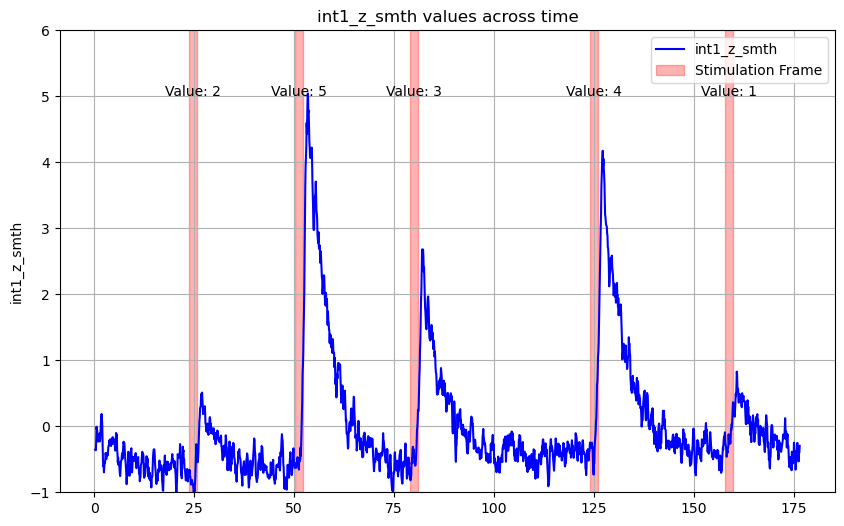

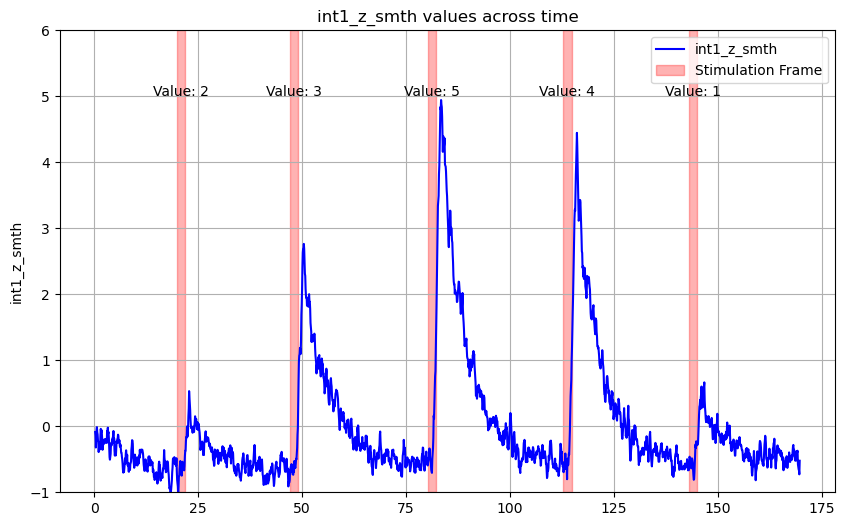

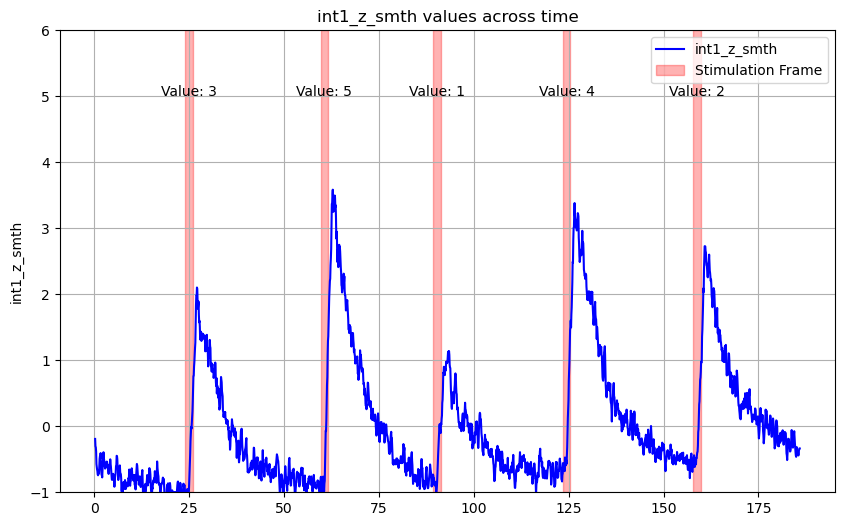

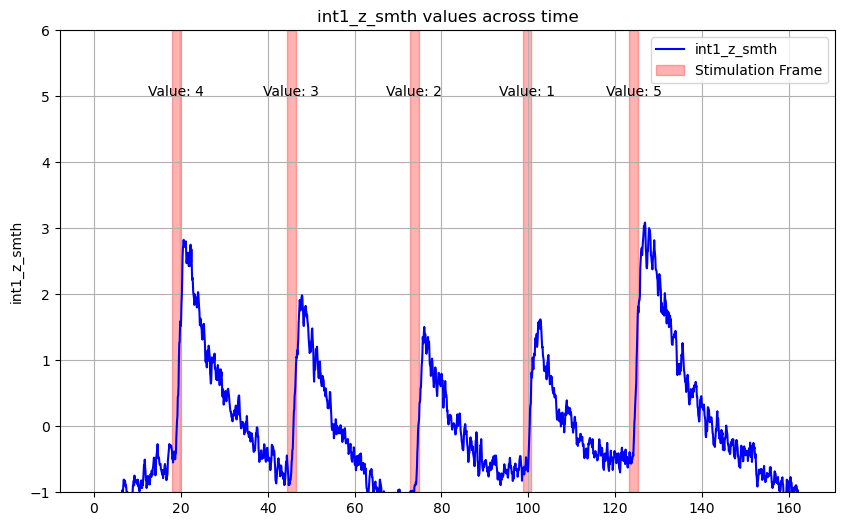

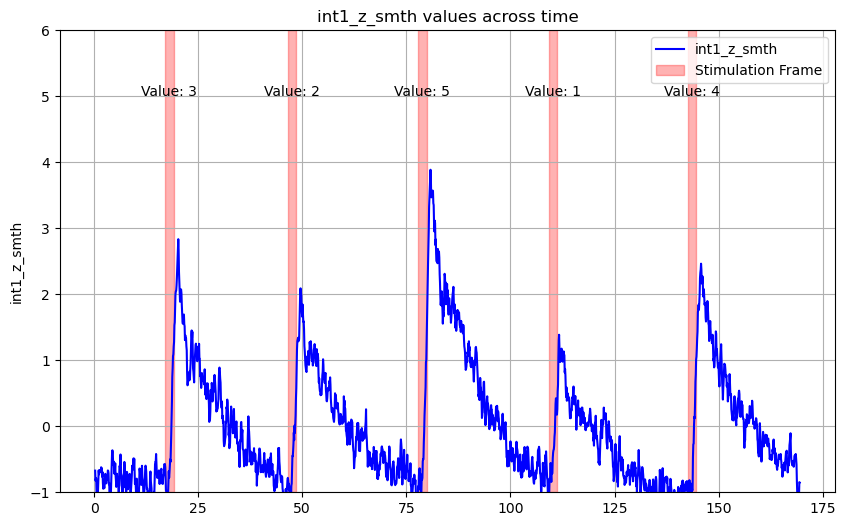

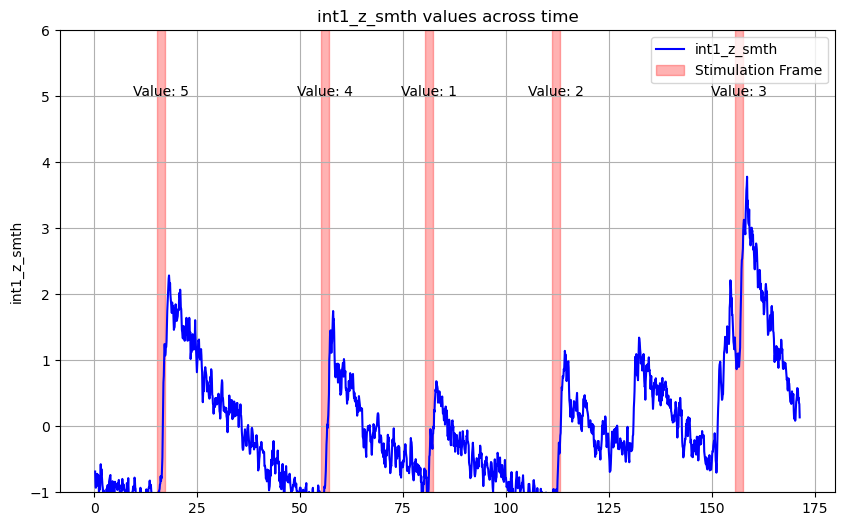

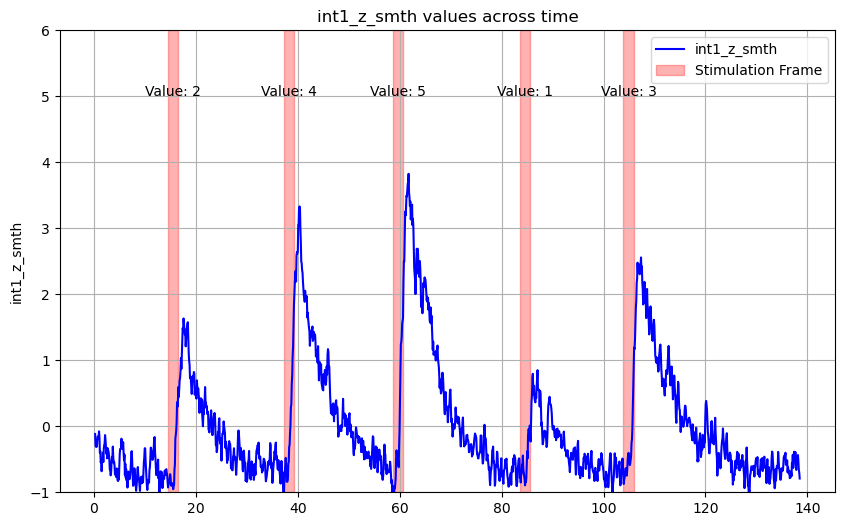

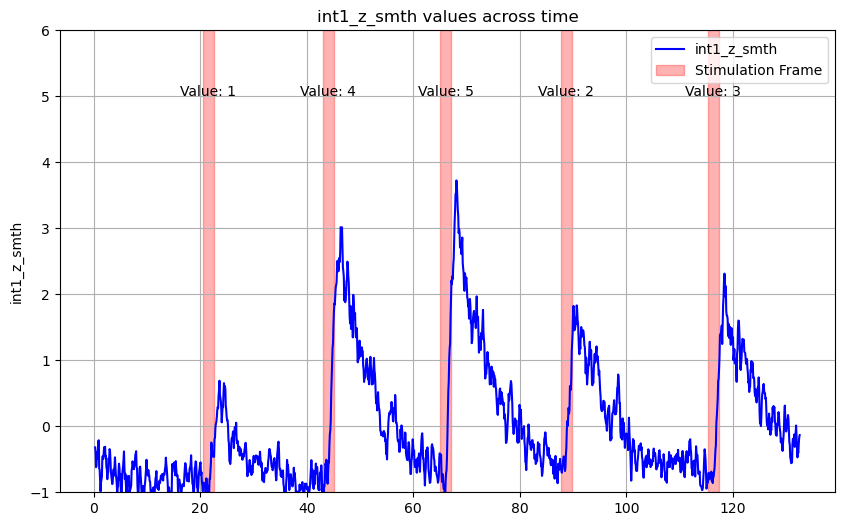

In [40]:
# Access the parent directory
parent_dir = Path(r'Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\Chrome')

# Loop through all folders starting with "brain"
for brain_folder in parent_dir.glob('brain*'):
    # Loop through all subfolders starting with "trial" within each brain folder
    for trial_folder in brain_folder.glob('trial*'):
        print(f'INFO: now processing {trial_folder}')
        
        # Selection rule: all ROI.csv files
        p_csvs = [*trial_folder.glob('**/ROI.csv')]

        # Selection rule: all Stimulation_Frames.xlsx files
        p_xlsx = [*trial_folder.glob('**/Stimulation_Frames.xlsx')]

        # Sampling rates
        f_rec = 11.82  # Original recording frequencies

        # Process the CSV and corresponding .mat files
        for p_csv in p_csvs:
            print(f'INFO: now parsing {p_csv}')
            
            # Process df_rec
            df_rec = pd.read_csv(p_csv)
            df_rec.rename(columns={df_rec.columns[0]: 'original frame'}, inplace=True)
            df_rec.index = range(1, len(df_rec) + 1)

            # Assuming the intensity values are in columns named 'Mean1' and 'Mean2'
            mean1_values = df_rec['Mean1'].values
            mean2_values = df_rec['Mean2'].values

            df_rec['int1'] = df_rec['Mean1'] - df_rec['Mean2']

            # Calculate z-scores for int1
            df_rec['int1_z'] = (df_rec['int1'] - df_rec['int1'].mean()) / df_rec['int1'].std()

            # Smooth the z-scored data using a moving average window of 5 frames
            df_rec['int1_z_smth'] = df_rec['int1_z'].rolling(window=5, center=True).mean()

            # Extract stimulation frames from the Stimulation_Frames.xlsx file
            df_stim = pd.read_excel(p_xlsx[0], header=None)

            # Get the first 4 values from the stimulation frames
            stim_frames = df_stim.iloc[:].values.flatten().tolist()

            # Path to the text document file
            text_file_path = next(trial_folder.glob('trial*.txt'))

            # Read the text document file
            with open(text_file_path, 'r') as file:
                lines = file.readlines()

            # Convert the values to a list of integers
            values = []
            for line in lines:
                values.extend([int(value) for value in line.split()])

            # Convert frames to seconds
            df_rec['time (s)'] = df_rec['original frame'] / f_rec

            # Create a figure
            fig, ax = plt.subplots(figsize=(10, 6))

            # Plot int1_z_smth values across time
            ax.plot(df_rec['time (s)'], df_rec['int1_z_smth'], label='int1_z_smth', color='blue')
            for stim_frame, value in zip(stim_frames, values):
                stim_time = stim_frame / f_rec
                ax.axvspan(stim_time - 1, stim_time + 1, color='red', alpha=0.3, label='Stimulation Frame' if stim_frame == stim_frames[0] else "")
                ax.text(stim_time, 5, f'Value: {value}', color='black', ha='center')
            ax.set_ylabel('int1_z_smth')
            ax.set_title('int1_z_smth values across time')
            ax.legend()
            ax.grid(True)
            ax.set_ylim(-1, 6)

            # Adjust layout
            #plt.tight_layout()
            #plt.show()

            # Save the figure as an SVG file
            fig.savefig(trial_folder / 'trial1.svg')

Create a data frame with all data

In [71]:
import pandas as pd
import numpy as np
from pathlib import Path

# Access the parent directory
parent_dir = Path(r'Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\ChrimsonR')

# Sampling rates
f_rec = 11.82  # Original recording frequencies

# Initialize an empty list to store data for all trials
master_data = []

# Define the frame window range
window_range_before = 36
window_range_after = 120

# Loop through all folders starting with "brain"
for brain_folder in parent_dir.glob('brain*'):
    # Loop through all subfolders starting with "trial" within each brain folder
    for trial_folder in brain_folder.glob('trial*'):
        print(f'INFO: now processing {trial_folder}')
        
        # Selection rule: all ROI.csv files
        p_csvs = [*trial_folder.glob('**/ROI.csv')]

        # Selection rule: all Stimulation_Frames.xlsx files
        p_xlsx = [*trial_folder.glob('**/Stimulation_Frames.xlsx')]

        # Find the text file in the trial folder
        text_file_path = next(trial_folder.glob('trial*.txt'), None)
        if not text_file_path:
            print(f"WARNING: No .txt file found in {trial_folder}")
            continue

        # Read the text file and extract the 5 stimulation values
        with open(text_file_path, 'r') as file:
            frequencies = [int(value) for line in file for value in line.split()]

        if len(frequencies) != 5:
            print(f"WARNING: Unexpected number of frequencies ({len(frequencies)}) in {text_file_path}")
            continue

        # Process the CSV and corresponding .mat files
        for p_csv in p_csvs:
            print(f'INFO: now parsing {p_csv}')
            
            # Process df_rec
            df_rec = pd.read_csv(p_csv)
            df_rec.rename(columns={df_rec.columns[0]: 'original frame'}, inplace=True)
            df_rec.index = range(1, len(df_rec) + 1)

            # Calculate int1
            df_rec['int1'] = df_rec['Mean1'] - df_rec['Mean2']

            # Extract stimulation frames from the Stimulation_Frames.xlsx file
            if p_xlsx:
                df_stim = pd.read_excel(p_xlsx[0], header=None)
                stim_frames = df_stim.iloc[:, 0].values.tolist()[:5]
            else:
                stim_frames = [None] * 5  # Placeholder if no stimulation frames available
            
            # Initialize columns for stimulation cycle and new_frames
            df_rec['stimulation_cycle'] = np.nan
            df_rec['frequency'] = np.nan
            df_rec['new_frames'] = np.nan

            # Process each stimulation frame
            for i, stim_frame in enumerate(stim_frames):
                if stim_frame is None:
                    continue
                
                # Define the window for the current stimulation cycle
                start_frame = stim_frame - window_range_before
                end_frame = stim_frame + window_range_after

                # Mark the rows within the window
                in_window = (df_rec['original frame'] >= start_frame) & (df_rec['original frame'] <= end_frame)
                df_rec.loc[in_window, 'stimulation_cycle'] = i + 1
                df_rec.loc[in_window, 'frequency'] = frequencies[i]
                df_rec.loc[in_window, 'new_frames'] = df_rec['original frame'] - stim_frame

            # Filter the DataFrame to keep only rows within the defined windows
            df_rec = df_rec[df_rec['stimulation_cycle'].notna()]

            # Calculate F0 for each stimulation cycle
            f0_values = {}
            for cycle in df_rec['stimulation_cycle'].unique():
                cycle_data = df_rec[df_rec['stimulation_cycle'] == cycle]
                stim_frame = stim_frames[int(cycle) - 1]
                window_start = stim_frame - window_range_before
                window_end = stim_frame

                # Adjust window boundaries
                session_window_data = cycle_data[(cycle_data['original frame'] >= window_start) & (cycle_data['original frame'] < window_end)]
                f0_values[cycle] = session_window_data['int1'].mean()

            # Map F0 values to the DataFrame
            df_rec['F0'] = df_rec['stimulation_cycle'].map(f0_values)

            # Calculate ΔF/F
            df_rec['dF/F0'] = (df_rec['int1'] - df_rec['F0']) / df_rec['F0']

            # Calculate z-scored ΔF/F
            df_rec['z-score dF/F0'] = (df_rec['dF/F0'] - df_rec['dF/F0'].mean()) / df_rec['dF/F0'].std()

            # Add metadata for tracking
            df_rec['brain'] = brain_folder.name
            df_rec['trial'] = trial_folder.name

            # Append to master data
            master_data.append(df_rec)

# Combine all trial data into a single DataFrame
master_df = pd.concat(master_data, ignore_index=True)

# Save the combined DataFrame to a CSV file for later use
master_df.to_csv(parent_dir / 'master_data_with_F0_dF_F0.csv', index=False)

print(f'Master DataFrame created with {len(master_df)} rows and saved to "master_data_stimulation_cycles.csv".')

INFO: now processing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\ChrimsonR\brain1\trial1
INFO: now parsing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\ChrimsonR\brain1\trial1\ROI.csv
INFO: now processing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\ChrimsonR\brain1\trial2
INFO: now parsing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\ChrimsonR\brain1\trial2\ROI.csv
INFO: now processing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\ChrimsonR\brain2\trial1
INFO: now parsing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\ChrimsonR\brain2\trial1\ROI.csv
INFO: now processing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\ChrimsonR\brain2\trial2
INFO: now parsing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\ChrimsonR\brain2\trial2\ROI.csv
INFO: now processing Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\Chrim

plot frequencies for specific brains and trials

In [ ]:
import matplotlib.pyplot as plt

# Filter the data for brain1 and trial1
specific_brain_trial_data = master_df[(master_df['brain'] == 'brain5') & (master_df['trial'] == 'trial1')]

# Group by 'new_frames' and 'frequency' and calculate the mean and SEM ΔF/F for each combination
grouped_data = specific_brain_trial_data.groupby(['new_frames', 'frequency'])['dF/F0']
averaged_dF_F = grouped_data.mean().reset_index()
sem_dF_F = grouped_data.sem().reset_index()

# Merge the mean and SEM dataframes
averaged_dF_F = averaged_dF_F.merge(sem_dF_F, on=['new_frames', 'frequency'], suffixes=('', '_sem'))

# Create a figure
plt.figure(figsize=(12, 8))

# Plot the average ΔF/F trace across time for each frequency on the same plot with SEM
for frequency in averaged_dF_F['frequency'].unique():
    frequency_data = averaged_dF_F[averaged_dF_F['frequency'] == frequency]
    plt.plot(frequency_data['new_frames'], frequency_data['dF/F0'], label=f'Frequency: {frequency} Hz')
    plt.fill_between(frequency_data['new_frames'], 
                     frequency_data['dF/F0'] - frequency_data['dF/F0_sem'], 
                     frequency_data['dF/F0'] + frequency_data['dF/F0_sem'], 
                     alpha=0.3)

# Add labels, title, and vertical line for stimulation frame
plt.xlabel('New Frames (Aligned to Stimulation)', fontsize=14)
plt.ylabel('Average ΔF/F', fontsize=14)
plt.axvline(0, color='red', linestyle='--', label='Stimulation Frame')  # Mark stimulation frame
plt.legend()
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the plot
plot_output_path = parent_dir
plt.savefig(plot_output_path)

# Show the plot
plt.tight_layout()
plt.show()

print(f"Plot saved to: {plot_output_path}")

plot averaged deltaF/F (across brains and trials) for different frequencies

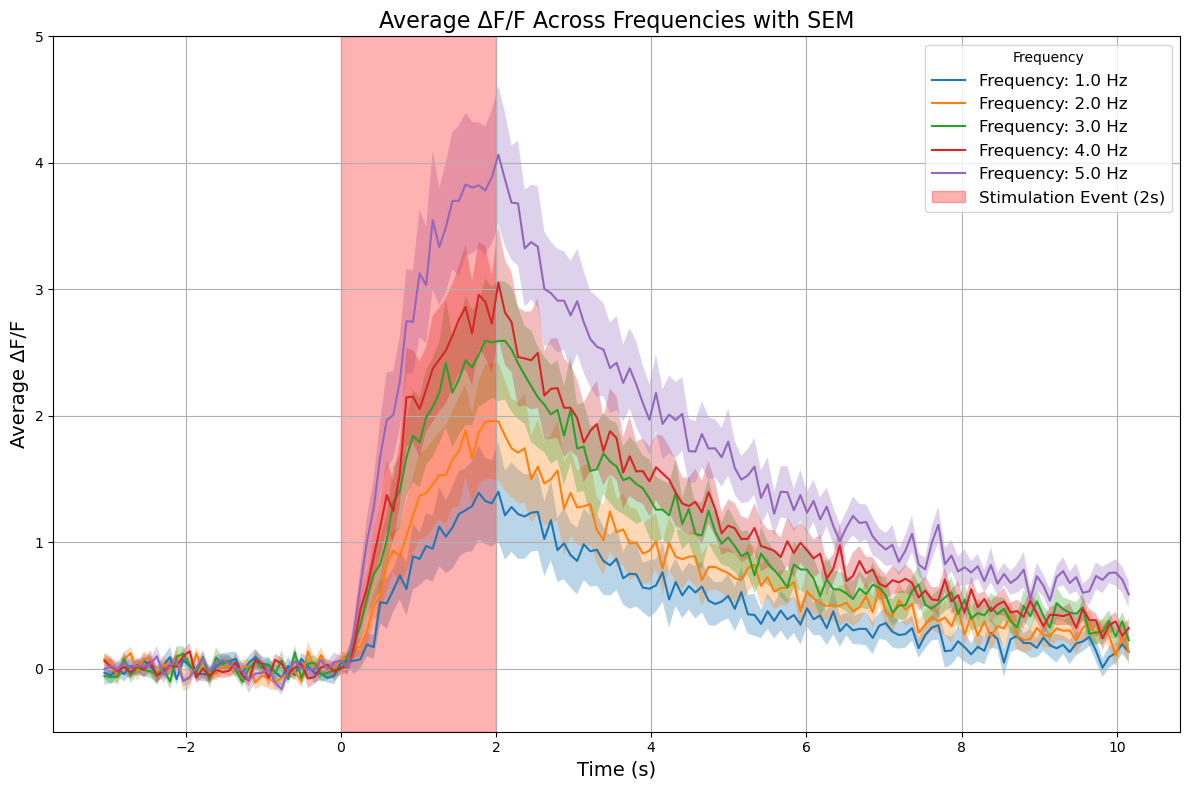

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming master_df is already created from your script
f_rec = 11.82  # Sampling rate (Hz)

# Group data by 'frequency' and 'new_frames' and calculate the mean and SEM
averaged_data = master_df.groupby(['frequency', 'new_frames'])['dF/F0'].agg(
    ['mean', 'sem']).reset_index()

# Convert frames to seconds
averaged_data['time_s'] = averaged_data['new_frames'] / f_rec

# Plotting
plt.figure(figsize=(12, 8))

plt.ylim(-0.5, 5)

# Loop through each frequency and plot the average ΔF/F with SEM
for frequency in averaged_data['frequency'].unique():
    # Get data for the current frequency
    freq_data = averaged_data[averaged_data['frequency'] == frequency]
    
    # Plot the mean ΔF/F trace (convert frames to seconds)
    plt.plot(freq_data['time_s'], freq_data['mean'], label=f'Frequency: {frequency} Hz')
    
    # Plot the SEM as a shaded area around the mean trace (with transparency)
    plt.fill_between(freq_data['time_s'], 
                     freq_data['mean'] - freq_data['sem'], 
                     freq_data['mean'] + freq_data['sem'], 
                     alpha=0.3)

# Add a solid vertical bar at 0s (stimulation time) with 2 seconds thickness, in red
plt.axvspan(0, 2, color='red', alpha=0.3, label='Stimulation Event (2s)')  # Adjusted alpha to 0.3

# Adding labels and title
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Average ΔF/F', fontsize=14)
plt.title('Average ΔF/F Across Frequencies with SEM', fontsize=16)
plt.legend(title='Frequency', loc='upper right', fontsize=12)
plt.grid(True)

# Save the figure as an SVG file in the parent directory location
parent_dir = Path(r'Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\ChrimsonR')
plt.savefig(parent_dir / 'average_dF_F.png', format='png')

# Show plot
plt.tight_layout()
plt.show()


plot averaged z-scored deltaF/F (across brains and trials) for different frequencies

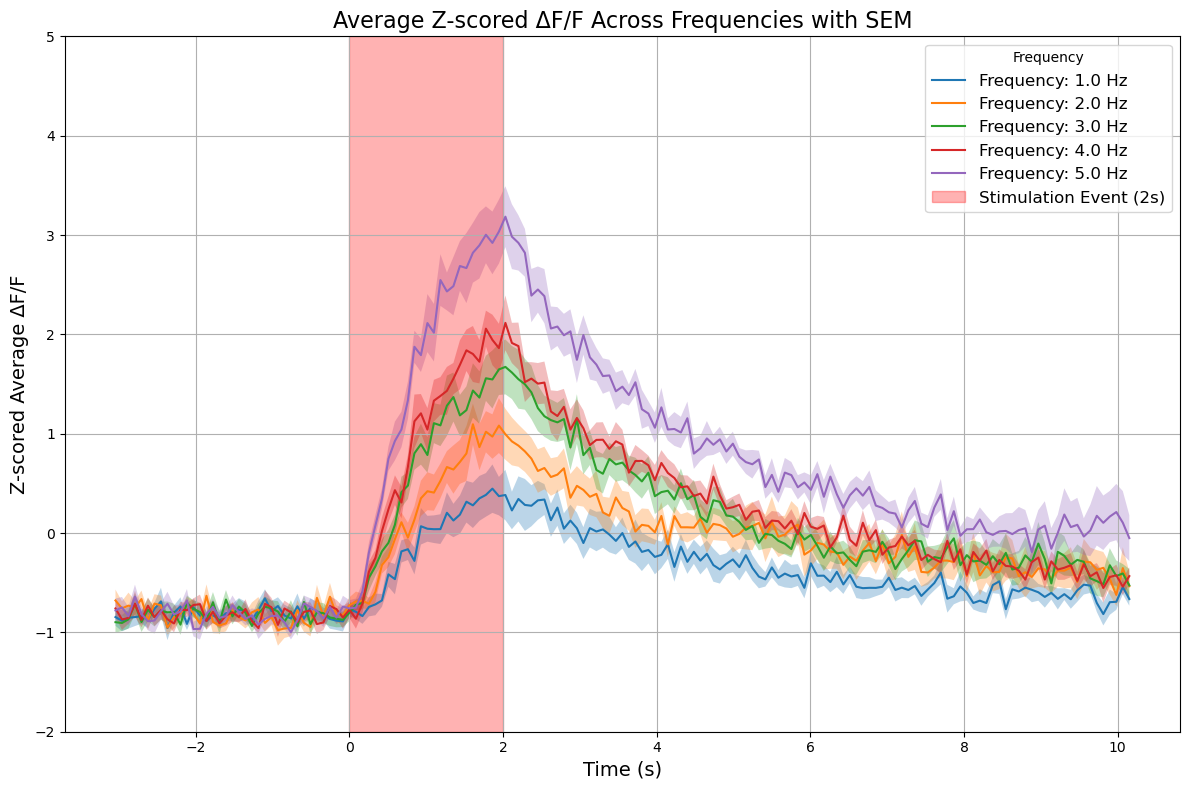

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming master_df is already created from your script
f_rec = 11.82  # Sampling rate (Hz)

# Group data by 'frequency' and 'new_frames' and calculate the mean and SEM
averaged_data = master_df.groupby(['frequency', 'new_frames'])['z-score dF/F0'].agg(
    ['mean', 'sem']).reset_index()

# Convert frames to seconds
averaged_data['time_s'] = averaged_data['new_frames'] / f_rec

# Plotting
plt.figure(figsize=(12, 8))

plt.ylim(-2, 5)

# Loop through each frequency and plot the average z-scored ΔF/F with SEM
for frequency in averaged_data['frequency'].unique():
    # Get data for the current frequency
    freq_data = averaged_data[averaged_data['frequency'] == frequency]
    
    # Plot the mean z-scored ΔF/F trace (convert frames to seconds)
    plt.plot(freq_data['time_s'], freq_data['mean'], label=f'Frequency: {frequency} Hz')
    
    # Plot the SEM as a shaded area around the mean trace (with transparency)
    plt.fill_between(freq_data['time_s'], 
                     freq_data['mean'] - freq_data['sem'], 
                     freq_data['mean'] + freq_data['sem'], 
                     alpha=0.3)

# Add a solid vertical bar at 0s (stimulation time) with 2 seconds thickness, in red
plt.axvspan(0, 2, color='red', alpha=0.3, label='Stimulation Event (2s)')

# Adding labels and title
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Z-scored Average ΔF/F', fontsize=14)
plt.title('Average Z-scored ΔF/F Across Frequencies with SEM', fontsize=16)
plt.legend(title='Frequency', loc='upper right', fontsize=12)
plt.grid(True)

# Save the figure as an SVG file in the parent directory location
parent_dir = Path(r'Z:\Nino\Projects\Holography\SpiralScanning\Data\Opsins\GH146\freq\ChrimsonR')
plt.savefig(parent_dir / 'average_zscored_dF_F.png', format='png')

# Show plot
plt.tight_layout()
plt.show()

Area under the curve

Regression Coefficient (Slope): 34.019520597400614
Intercept: 27.6538582345368


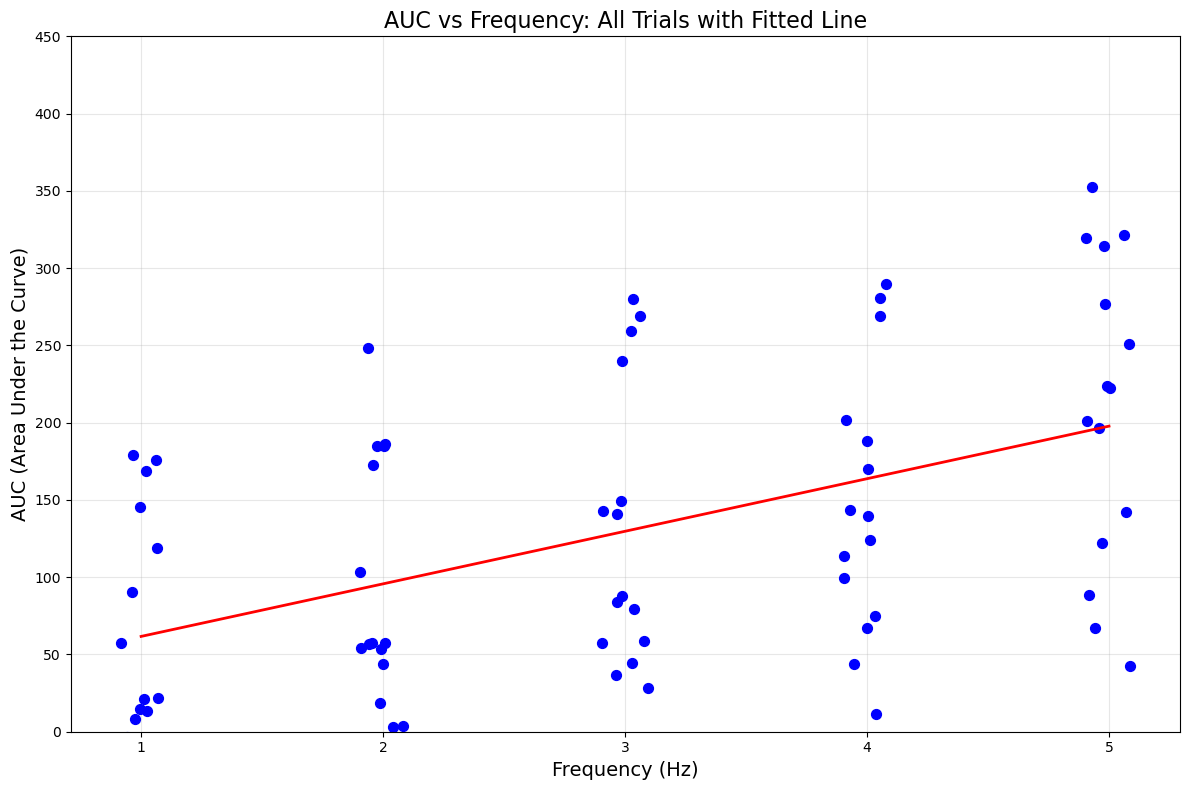

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Calculate AUC for each trial and frequency directly
trial_aucs = []
for (freq, brain, trial), group in master_df.groupby(['frequency', 'brain', 'trial']):
    auc_value = np.trapz(group['dF/F0'], group['new_frames'])
    trial_aucs.append({'frequency': freq, 'brain': brain, 'trial': trial, 'AUC': auc_value})

# Convert to DataFrame
trial_aucs = pd.DataFrame(trial_aucs)

# Create the plot
plt.figure(figsize=(12, 8))

plt.ylim(0, 450)


# Store AUCs and frequencies for regression
all_aucs = trial_aucs['AUC'].values
all_frequencies = trial_aucs['frequency'].values

# Plot individual AUCs with jitter
positions = np.arange(len(all_frequencies))
jitter = np.random.uniform(-0.1, 0.1, len(all_aucs))  # Random jitter to avoid overlap
plt.scatter(all_frequencies + jitter, all_aucs, color='blue', s=50, zorder=2)  # Individual AUCs

# Fit a linear regression line across all frequencies
X = all_frequencies.reshape(-1, 1)  # Reshape for regression
y = all_aucs
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Get the coefficient (slope) and intercept
slope = model.coef_[0]
intercept = model.intercept_

# Print the regression coefficient and intercept
print(f'Regression Coefficient (Slope): {slope}')
print(f'Intercept: {intercept}')

# Plot the regression line
plt.plot(X, y_pred, color='red', linewidth=2, zorder=3)  # Fitted line

# Customize plot labels and title
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('AUC (Area Under the Curve)', fontsize=14)
plt.title('AUC vs Frequency: All Trials with Fitted Line', fontsize=16)
plt.grid(alpha=0.3)

# Save the plot
plt.tight_layout()
plt.savefig(parent_dir / 'auc_vs_frequency_with_fitted_line_and_coefficients.svg', format='svg')

# Show the plot
plt.show()
